In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

register_matplotlib_converters()
from time import time

# Catfish Sales Data

In [3]:
def parser(s):
    return datetime.strptime(s, "%Y-%m-%d")

In [4]:
# read data
catfish_sales = pd.read_csv(
    "data/catfish.csv", parse_dates=[0], index_col=0, squeeze=True, date_parser=parser
)

In [5]:
# infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [6]:
start_date = datetime(1996, 1, 1)
end_date = datetime(2000, 1, 1)
lim_catfish_sales = catfish_sales[start_date:end_date]

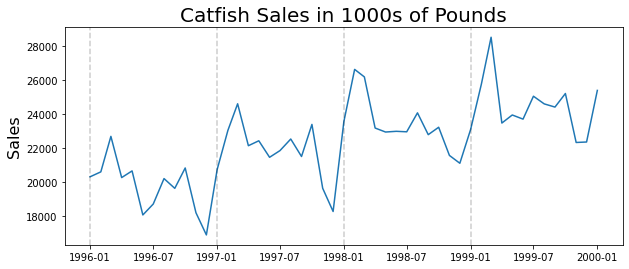

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(lim_catfish_sales)
plt.title("Catfish Sales in 1000s of Pounds", fontsize=20)
plt.ylabel("Sales", fontsize=16)
for year in range(start_date.year, end_date.year):
    plt.axvline(
        pd.to_datetime(str(year) + "-01-01"), color="k", linestyle="--", alpha=0.2
    )

## Remove the trend

In [8]:
first_diff = lim_catfish_sales.diff()[1:]

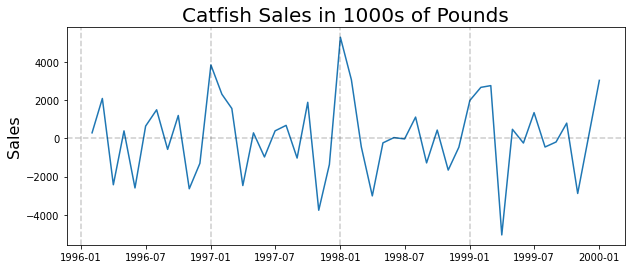

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(first_diff)
plt.title("Catfish Sales in 1000s of Pounds", fontsize=20)
plt.ylabel("Sales", fontsize=16)
for year in range(start_date.year, end_date.year):
    plt.axvline(
        pd.to_datetime(str(year) + "-01-01"), color="k", linestyle="--", alpha=0.2
    )
plt.axhline(0, color="k", linestyle="--", alpha=0.2)

# ACF

<BarContainer object of 20 artists>

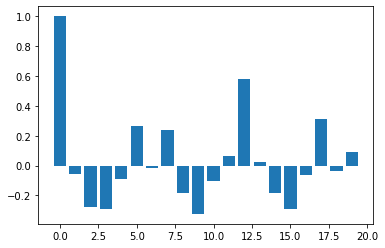

In [12]:
num_lags = 20
acf_vals = acf(first_diff, nlags=num_lags)
plt.bar(range(num_lags), acf_vals[:num_lags])

## Based on ACF, we should start with a seasonal MA process

# PACF

<BarContainer object of 15 artists>

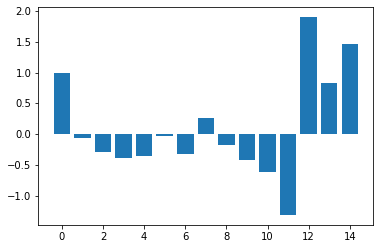

In [13]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

## Based on PACF, we should start with a seasonal AR process

# Get training and testing sets

In [14]:
train_end = datetime(1999, 7, 1)
test_end = datetime(2000, 1, 1)

train_data = lim_catfish_sales[:train_end]
test_data = lim_catfish_sales[train_end + timedelta(days=1) : test_end]

# Fit the SARIMA Model

In [15]:
my_order = (0, 1, 0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [16]:
# fit the model
start = time()
model_fit = model.fit()
end = time()
print("Model Fitting Time:", end - start)

/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87226D+00    |proj g|=  1.21498D+00

At iterate    5    f=  8.58466D+00    |proj g|=  3.02756D-01

At iterate   10    f=  8.55794D+00    |proj g|=  1.37591D-03

At iterate   15    f=  8.55794D+00    |proj g|=  1.03692D-03

At iterate   20    f=  8.55777D+00    |proj g|=  2.65797D-02

At iterate   25    f=  8.53991D+00    |proj g|=  1.21574D-01

At iterate   30    f=  8.51121D+00    |proj g|=  1.27036D-02

At iterate   35    f=  8.50342D+00    |proj g|=  2.99368D-02

At iterate   40    f=  8.50313D+00    |proj g|=  7.48912D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

In [17]:
# summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Thu, 27 Oct 2022   AIC                            737.269
Time:                                      12:24:01   BIC                            742.482
Sample:                                  01-01-1996   HQIC                           739.180
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8250      0.120      6.848      0.000       0.589       1.061
ma.S.L12      -0.51

In [18]:
# get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

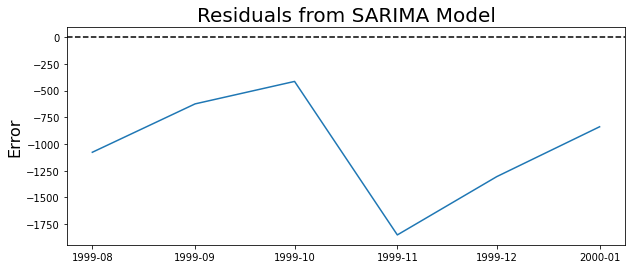

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.axhline(0, linestyle="--", color="k")
plt.title("Residuals from SARIMA Model", fontsize=20)
plt.ylabel("Error", fontsize=16)

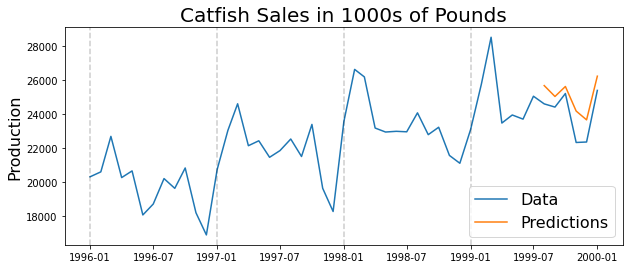

In [20]:
plt.figure(figsize=(10, 4))

plt.plot(lim_catfish_sales)
plt.plot(predictions)

plt.legend(("Data", "Predictions"), fontsize=16)

plt.title("Catfish Sales in 1000s of Pounds", fontsize=20)
plt.ylabel("Production", fontsize=16)
for year in range(start_date.year, end_date.year):
    plt.axvline(
        pd.to_datetime(str(year) + "-01-01"), color="k", linestyle="--", alpha=0.2
    )

In [21]:
print("Mean Absolute Percent Error:", round(np.mean(abs(residuals / test_data)), 4))

Mean Absolute Percent Error: 0.0433


In [22]:
print("Root Mean Squared Error:", np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1122.306122326815


# Using the Rolling Forecast Origin

In [23]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[: train_end - timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/masoud/anaconda3/envs/coding_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87226D+00    |proj g|=  1.21498D+00

At iterate    5    f=  8.58466D+00    |proj g|=  3.02756D-01

At iterate   10    f=  8.55794D+00    |proj g|=  1.37591D-03

At iterate   15    f=  8.55794D+00    |proj g|=  1.03692D-03

At iterate   20    f=  8.55777D+00    |proj g|=  2.65797D-02

At iterate   25    f=  8.53991D+00    |proj g|=  1.21574D-01

At iterate   30    f=  8.51121D+00    |proj g|=  1.27036D-02

At iterate   35    f=  8.50342D+00    |proj g|=  2.99368D-02

At iterate   40    f=  8.50313D+00    |proj g|=  7.48912D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   15    f=  8.54326D+00    |proj g|=  1.18110D-03

At iterate   20    f=  8.54311D+00    |proj g|=  1.41033D-02

At iterate   25    f=  8.53548D+00    |proj g|=  3.21838D-02

At iterate   30    f=  8.51591D+00    |proj g|=  1.27088D-02

At iterate   35    f=  8.50578D+00    |proj g|=  6.02840D-03

At iterate   40    f=  8.50171D+00    |proj g|=  6.17174D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     41     52      1     0     0   1.388D-05   8.502D+00
  F =   8.5017078612175006     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   35    f=  8.49514D+00    |proj g|=  4.26954D-02

At iterate   40    f=  8.49427D+00    |proj g|=  1.64155D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     40     49      1     0     0   1.642D-05   8.494D+00
  F =   8.4942658995533158     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.55780D+00    |proj g|=  7.16548D-01

At iterate    5    f=  8.51880D+00    |proj g|=  4.75771D-03


 This problem is unconstrained.



At iterate   10    f=  8.51132D+00    |proj g|=  8.78852D-02

At iterate   15    f=  8.49091D+00    |proj g|=  9.38814D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     37      1     0     0   8.543D-05   8.491D+00
  F =   8.4908943256492044     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.06581D+00    |proj g|=  1.88124D+00


 This problem is unconstrained.



At iterate    5    f=  8.55282D+00    |proj g|=  2.36256D-01

At iterate   10    f=  8.49130D+00    |proj g|=  4.95823D-03

At iterate   15    f=  8.49126D+00    |proj g|=  1.16119D-04

At iterate   20    f=  8.49124D+00    |proj g|=  1.14618D-03

At iterate   25    f=  8.49039D+00    |proj g|=  5.34783D-03

At iterate   30    f=  8.48985D+00    |proj g|=  1.32515D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     36      1     0     0   1.199D-05   8.490D+00
  F =   8.4898467450436055     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  8.49611D+00    |proj g|=  4.94412D-04

At iterate   20    f=  8.49595D+00    |proj g|=  3.09002D-03

At iterate   25    f=  8.48916D+00    |proj g|=  1.73221D-02

At iterate   30    f=  8.48339D+00    |proj g|=  5.85205D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     39      1     0     0   1.902D-07   8.483D+00
  F =   8.4833339341635714     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [24]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

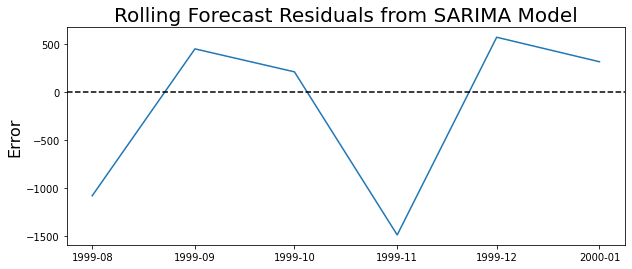

In [25]:
plt.figure(figsize=(10, 4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle="--", color="k")
plt.title("Rolling Forecast Residuals from SARIMA Model", fontsize=20)
plt.ylabel("Error", fontsize=16)

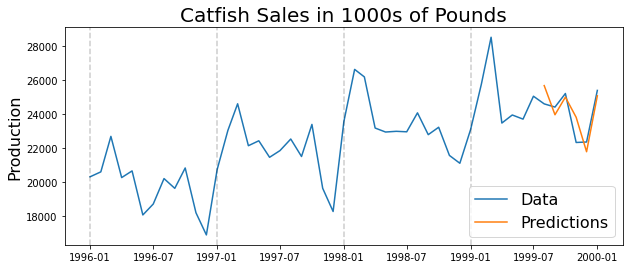

In [26]:
plt.figure(figsize=(10, 4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(("Data", "Predictions"), fontsize=16)

plt.title("Catfish Sales in 1000s of Pounds", fontsize=20)
plt.ylabel("Production", fontsize=16)
for year in range(start_date.year, end_date.year):
    plt.axvline(
        pd.to_datetime(str(year) + "-01-01"), color="k", linestyle="--", alpha=0.2
    )

In [27]:
print(
    "Mean Absolute Percent Error:",
    round(np.mean(abs(rolling_residuals / test_data)), 4),
)

Mean Absolute Percent Error: 0.0292


In [28]:
print("Root Mean Squared Error:", np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 820.7020368765593
